In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.api import stats
from statsmodels.stats.anova import anova_lm

from matplotlib.lines import Line2D


Import raw data from local drive. 

In [72]:
file_name = "Experimental_Structure_Data_05032025.xlsx"

fish = pd.read_excel(file_name, sheet_name='Fish')
relief = pd.read_excel(file_name, sheet_name='Relief')
species_codes = pd.read_excel(file_name, sheet_name='Species_Codes')

## Prepare Data

Calculate mean relief of each transect. Calculate standardized metrics for relief and substrate for each transect, and categorize transects as "High" or "Low" relief based on whether the mean relief values fall above or below 1.5, respectively. 

In [73]:
mean_relief= relief.groupby('Transect_Number')['Relief'].mean().reset_index(name='Mean_Relief')

mean_relief['Relief_Category'] = mean_relief['Mean_Relief'].apply(
    lambda x: 'High' if x >= 1.5 else 'Low'
)

Clean and prepare fish data. Calculate weighted size using size class data and pivot fish variables into workable format. 

In [74]:
fish_master = fish.merge(species_codes, on='Species', how='right')
fish_master = fish_master.merge(mean_relief, on = 'Transect_Number', how = 'right')

metadata = ['Date', 'Location', 'Recorder', 
                    'Buddy', 'Heading', 'Depth_ft', 'Unnamed: 13']

fish_master = fish_master.drop(columns=metadata)
fish_master

,Transect_Number,Treatment,Treatment_Time,Position,Species,Size_cm,Count,Species.1,Common_Name,Mobility,Mean_Relief,Relief_Category
0,2,Post-Kelp,1_hour,Benthic,SSER,25.0,1,RVAC,Olive rockfish,Intermediate,2.2,High
1,2,Pre-Kelp,0_hours,Mid-Column,SMYS,15.0,6,SATR,Blue rockfish,Midcolumn,2.2,High
2,2,Pre-Kelp,0_hours,Mid-Column,SMYS,20.0,6,EJAC,Blue rockfish,Midcolumn,2.2,High
3,2,Post-Kelp,1_hour,Mid-Column,SMYS,5.0,1,SMEL,Blue rockfish,Midcolumn,2.2,High
4,2,Post-Kelp,1_hour,Mid-Column,SMYS,15.0,4,NaN,Blue rockfish,Midcolumn,2.2,High
...,...,...,...,...,...,...,...,...,...,...,...,...
166,11,Post-Kelp,1_hour,NaN,HDEC,30.0,1,NaN,Kelp greenling,Benthic,1.5,High
167,11,Pre-Kelp,0_hours,NaN,OPIC,15.0,1,NaN,Painted greenling,Benthic,1.5,High
168,11,Post-Kelp,1_hour,NaN,OPIC,5.0,1,NaN,Painted greenling,Benthic,1.5,High
169,11,Pre-Kelp,0_hours,NaN,ELAT,15.0,11,NaN,Striped surfperch,Intermediate,1.5,High


Calculate total abundance, density, richness, biodiversity, and weighted size by transect and relief cateogry. 

In [90]:
# Compute Weighted Size
fish_master['Weighted_Size_cm'] = fish_master['Size_cm'] * fish_master['Count']

# Group once and compute multiple aggregations
aggregated = fish_master.groupby(['Transect_Number', 'Treatment_Time', 'Relief_Category', 'Mobility']).agg(
    total_abundance=('Count', 'sum'),
    total_density=('Count', lambda x: x.sum() / 20),
    total_weighted_size=('Weighted_Size_cm', 'sum'),
    total_richness=('Species', 'nunique')
).reset_index()

# Define Shannon Index function
def shannon_diversity(group):
    species_counts = group['Count']
    proportions = species_counts / species_counts.sum()
    return -(proportions * np.log(proportions)).sum()

# Apply Shannon Index separately
shannon = fish_master.groupby(['Transect_Number', 'Treatment_Time', 'Relief_Category', 'Mobility']).apply(
    shannon_diversity
).reset_index(name='total_biodiversity')

# Merge Shannon back into the main stats
fish_stats = aggregated.merge(shannon, on=['Transect_Number', 'Treatment_Time', 'Relief_Category', 'Mobility'], how='left')

# Display result
fish_stats


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\2463292221.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shannon = fish_master.groupby(['Transect_Number', 'Treatment_Time', 'Relief_Category', 'Mobility']).apply(


,Transect_Number,Treatment_Time,Relief_Category,Mobility,total_abundance,total_density,total_weighted_size,total_richness,total_biodiversity
0,2,0_hours,High,Intermediate,1,0.05,25.0,1,-0.000000
1,2,0_hours,High,Midcolumn,22,1.10,260.0,1,1.067090
2,2,1_hour,High,Intermediate,2,0.10,40.0,2,0.693147
3,2,1_hour,High,Midcolumn,16,0.80,300.0,1,1.180305
4,2,1_week,High,Intermediate,1,0.05,25.0,1,-0.000000
...,...,...,...,...,...,...,...,...,...
62,11,0_hours,High,Intermediate,12,0.60,180.0,2,0.286836
63,11,0_hours,High,Midcolumn,13,0.65,145.0,1,0.540204
64,11,1_hour,High,Benthic,8,0.40,100.0,4,1.494175
65,11,1_hour,High,Intermediate,1,0.05,15.0,1,-0.000000


## Fish Metrics by Treatment Time

### Summarize density, biodiversity, and size 

In [91]:
melted_df = pd.melt(fish_stats, id_vars=['Transect_Number', 'Treatment_Time', 'Relief_Category', 'Mobility'],
                    value_vars=['total_density', 'total_weighted_size', 'total_richness', 'total_biodiversity'],
                    var_name='Metric', value_name='Value')
melted_df

,Transect_Number,Treatment_Time,Relief_Category,Mobility,Metric,Value
0,2,0_hours,High,Intermediate,total_density,0.050000
1,2,0_hours,High,Midcolumn,total_density,1.100000
2,2,1_hour,High,Intermediate,total_density,0.100000
3,2,1_hour,High,Midcolumn,total_density,0.800000
4,2,1_week,High,Intermediate,total_density,0.050000
...,...,...,...,...,...,...
263,11,0_hours,High,Intermediate,total_biodiversity,0.286836
264,11,0_hours,High,Midcolumn,total_biodiversity,0.540204
265,11,1_hour,High,Benthic,total_biodiversity,1.494175
266,11,1_hour,High,Intermediate,total_biodiversity,-0.000000


In [93]:
# Function to compute one-way ANOVA by a single factor
def run_one_way_anova(stats, metric, factor_column):
    """
    Run a one-way ANOVA to analyze the effect of a single factor (e.g., Treatment_Time, Relief_Category, Mobility)
    on a given metric.
    
    Parameters:
    - stats: DataFrame containing the data
    - metric: The name of the metric (e.g., 'total_density')
    - factor_column: The name of the factor (e.g., 'Mobility')
    
    Returns:
    - ANOVA table
    """
    # Filter data for the selected metric
    metric_data = stats[stats['Metric'] == metric]
    
    # Fit the model for one-way ANOVA (effect of the factor on the metric)
    model = ols(f'Value ~ C({factor_column})', data=metric_data).fit()
    anova_table = anova_lm(model, typ=2)  # Type II Sum of Squares (tests main effects)
    
    print(f"\nANOVA Results for {metric} by {factor_column}:")
    print(anova_table)
    
    return anova_table

# Function to perform Tukey's HSD post-hoc test after ANOVA
def run_tukey_hsd(stats, metric, factor_column):
    """
    Perform Tukey's HSD post-hoc test for pairwise comparisons after ANOVA.
    
    Parameters:
    - stats: DataFrame containing the data
    - metric: The name of the metric (e.g., 'total_density')
    - factor_column: The name of the factor (e.g., 'Mobility')
    
    Returns:
    - Tukey HSD summary
    """
    # Filter data for the selected metric
    metric_data = stats[stats['Metric'] == metric].dropna()
    
    # Perform Tukey's HSD
    tukey = pairwise_tukeyhsd(metric_data['Value'], metric_data[factor_column], alpha=0.05)
    
    print(f"\nTukey HSD Results for {metric} by {factor_column}:")
    print(tukey.summary())
    
    return tukey

# Define metrics and factors
metrics = ['total_density', 'total_weighted_size', 'total_richness', 'total_biodiversity']
factors = ['Mobility', 'Treatment_Time', 'Relief_Category']

# Loop through each metric and factor to perform ANOVA and Tukey's HSD
for metric in metrics:
    for factor in factors:
        print(f"\n### Analyzing {metric} by {factor} ###")
        
        # Run One-Way ANOVA for each factor
        anova_results = run_one_way_anova(melted_df, metric, factor)
        
        # Check if ANOVA is significant (p-value < 0.05)
        if anova_results['PR(>F)'][0] < 0.05:
            print(f"\nSince ANOVA was significant, running Tukey's HSD for {metric} by {factor}...\n")
            # Run Tukey's HSD if ANOVA is significant
            run_tukey_hsd(melted_df, metric, factor)
        else:
            print(f"\nNo significant difference found by {factor} for {metric}. No need for Tukey's HSD test.")



### Analyzing total_density by Mobility ###

ANOVA Results for total_density by Mobility:
                sum_sq    df          F        PR(>F)
C(Mobility)  12.704530   2.0  25.317863  7.934500e-09
Residual     16.057634  64.0        NaN           NaN

Since ANOVA was significant, running Tukey's HSD for total_density by Mobility...


Tukey HSD Results for total_density by Mobility:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj  lower  upper  reject
--------------------------------------------------------------
     Benthic Intermediate  -0.1662 0.541 -0.5417 0.2093  False
     Benthic    Midcolumn   0.7985   0.0   0.441 1.1559   True
Intermediate    Midcolumn   0.9647   0.0   0.612 1.3173   True
--------------------------------------------------------------

### Analyzing total_density by Treatment_Time ###

ANOVA Results for total_density by Treatment_Time:
                      sum_sq    df         F    PR(>F)
C(Treatment_Ti

C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\3371202190.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['PR(>F)'][0] < 0.05:
C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\3371202190.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['PR(>F)'][0] < 0.05:
C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\3371202190.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['


Tukey HSD Results for total_density by Relief_Category:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper reject
--------------------------------------------------
  High    Low  -0.3274 0.0434 -0.6448 -0.01   True
--------------------------------------------------

### Analyzing total_weighted_size by Mobility ###

ANOVA Results for total_weighted_size by Mobility:
                    sum_sq    df          F        PR(>F)
C(Mobility)  385522.661487   2.0  18.206128  5.502805e-07
Residual     677613.905678  64.0        NaN           NaN

Since ANOVA was significant, running Tukey's HSD for total_weighted_size by Mobility...



C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\3371202190.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['PR(>F)'][0] < 0.05:



Tukey HSD Results for total_weighted_size by Mobility:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj  lower    upper   reject
-----------------------------------------------------------------
     Benthic Intermediate -10.0119 0.948 -87.1511  67.1273  False
     Benthic    Midcolumn 150.3269   0.0  76.8949 223.7589   True
Intermediate    Midcolumn 160.3388   0.0  87.9018 232.7759   True
-----------------------------------------------------------------

### Analyzing total_weighted_size by Treatment_Time ###

ANOVA Results for total_weighted_size by Treatment_Time:
                         sum_sq    df         F    PR(>F)
C(Treatment_Time)  1.089979e+04   2.0  0.331478  0.719087
Residual           1.052237e+06  64.0       NaN       NaN

No significant difference found by Treatment_Time for total_weighted_size. No need for Tukey's HSD test.

### Analyzing total_weighted_size by Relief_Category ###

ANOVA Results for total_weig

C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\3371202190.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['PR(>F)'][0] < 0.05:
C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\3371202190.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['PR(>F)'][0] < 0.05:
C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\3371202190.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['


Tukey HSD Results for total_richness by Mobility:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
     Benthic Intermediate  -1.1214    0.0 -1.5876 -0.6553   True
     Benthic    Midcolumn  -1.4346    0.0 -1.8784 -0.9909   True
Intermediate    Midcolumn  -0.3132 0.2069 -0.7509  0.1246  False
----------------------------------------------------------------

### Analyzing total_richness by Treatment_Time ###

ANOVA Results for total_richness by Treatment_Time:
                      sum_sq    df         F    PR(>F)
C(Treatment_Time)   1.051874   2.0  0.696157  0.502232
Residual           48.351111  64.0       NaN       NaN

No significant difference found by Treatment_Time for total_richness. No need for Tukey's HSD test.

### Analyzing total_richness by Relief_Category ###

ANOVA Results for total_richness by Relief_Category:
                

C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\3371202190.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['PR(>F)'][0] < 0.05:
C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\3371202190.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['PR(>F)'][0] < 0.05:
C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\3371202190.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['

### Plot the data


### Plotting total_density by Mobility ###


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\615311356.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)


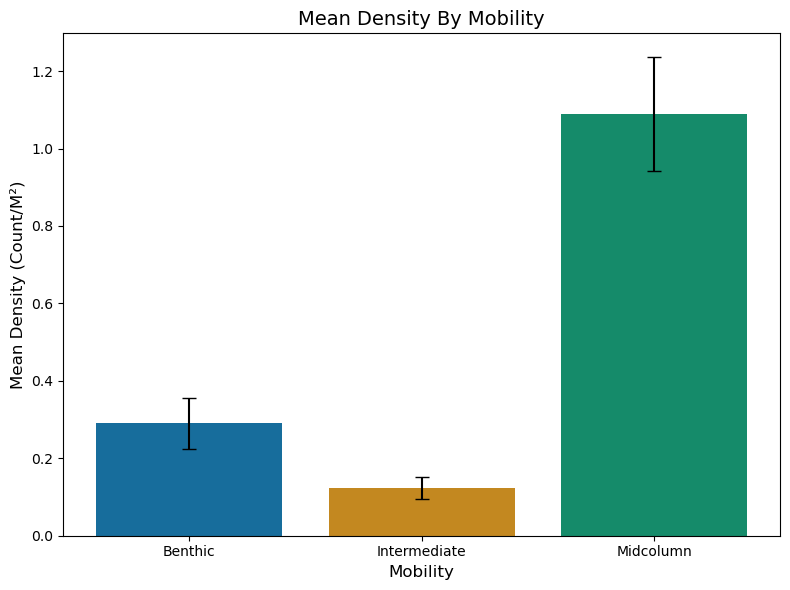


### Plotting total_density by Treatment_Time ###


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\615311356.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)


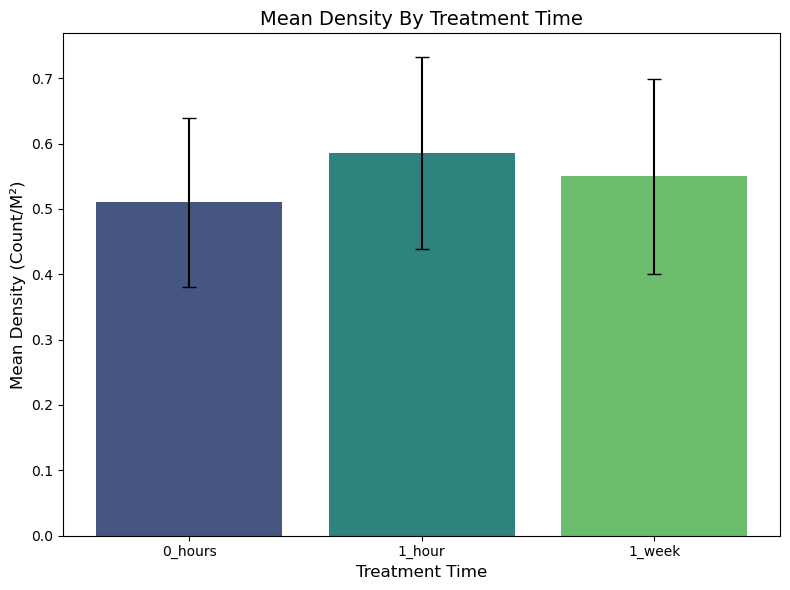


### Plotting total_density by Relief_Category ###


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\615311356.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)


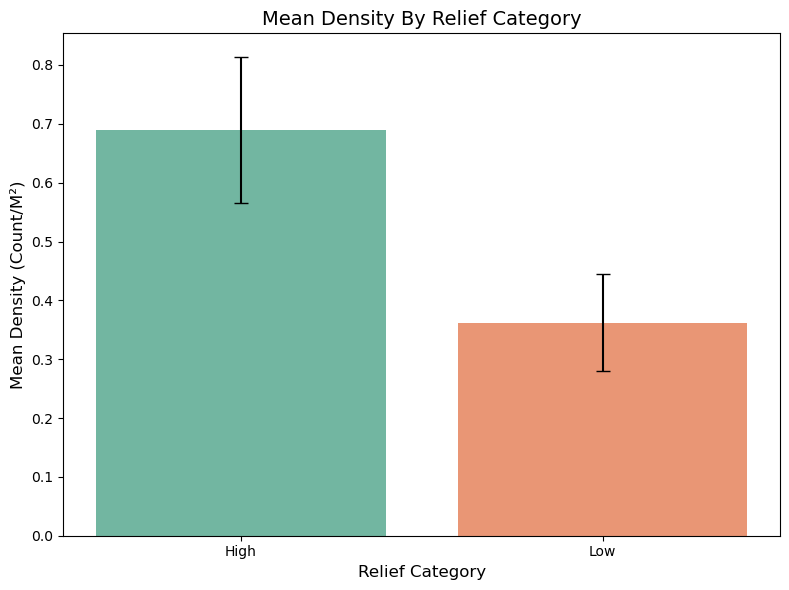


### Plotting total_weighted_size by Mobility ###


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\615311356.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)


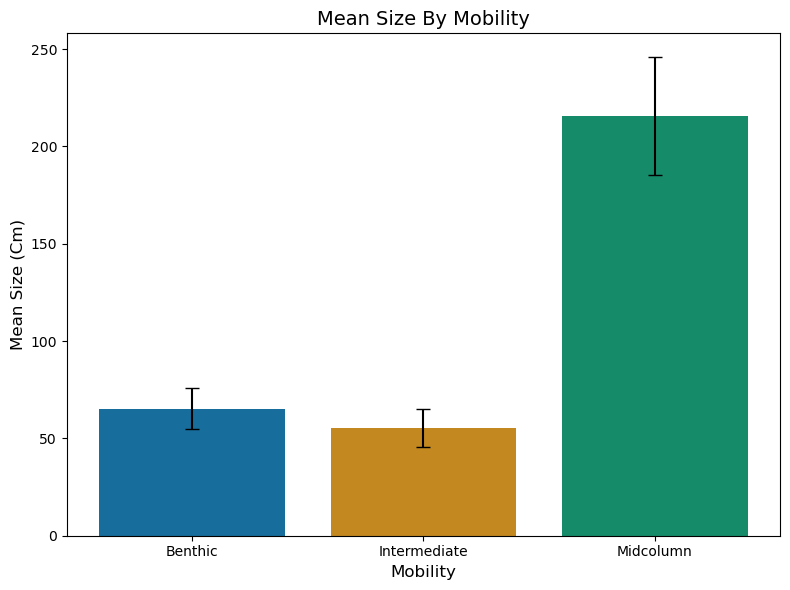


### Plotting total_weighted_size by Treatment_Time ###


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\615311356.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)


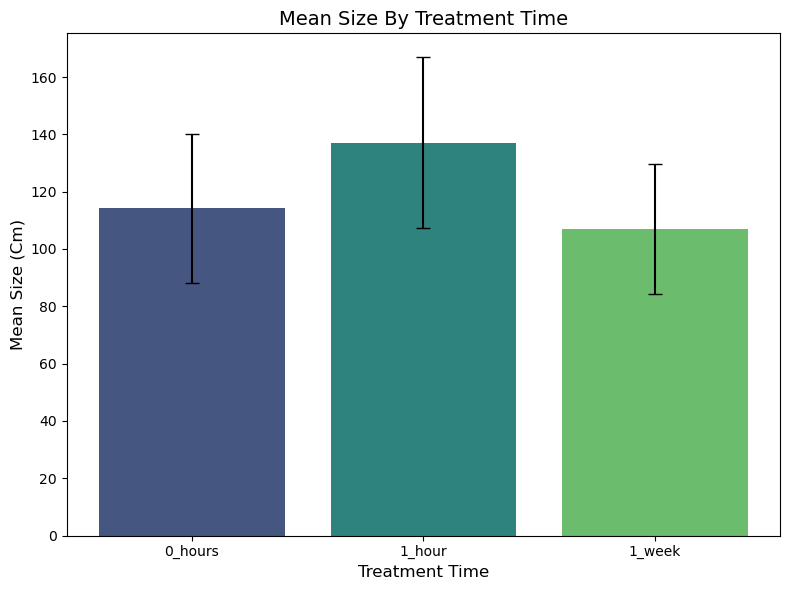


### Plotting total_weighted_size by Relief_Category ###


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\615311356.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)


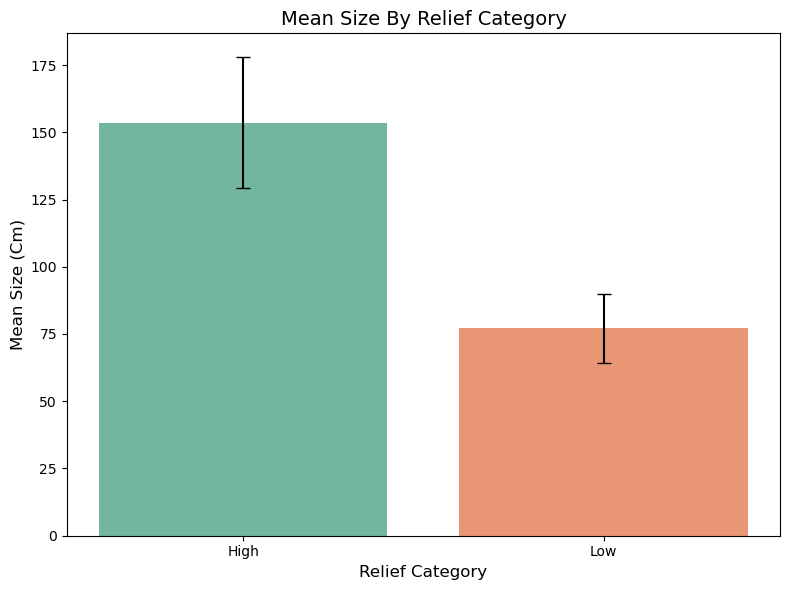


### Plotting total_richness by Mobility ###


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\615311356.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)


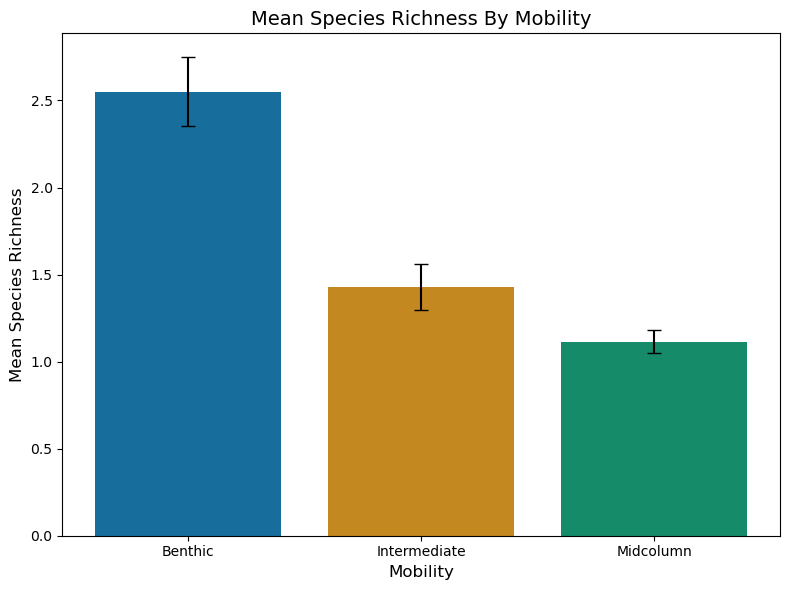


### Plotting total_richness by Treatment_Time ###


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\615311356.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)


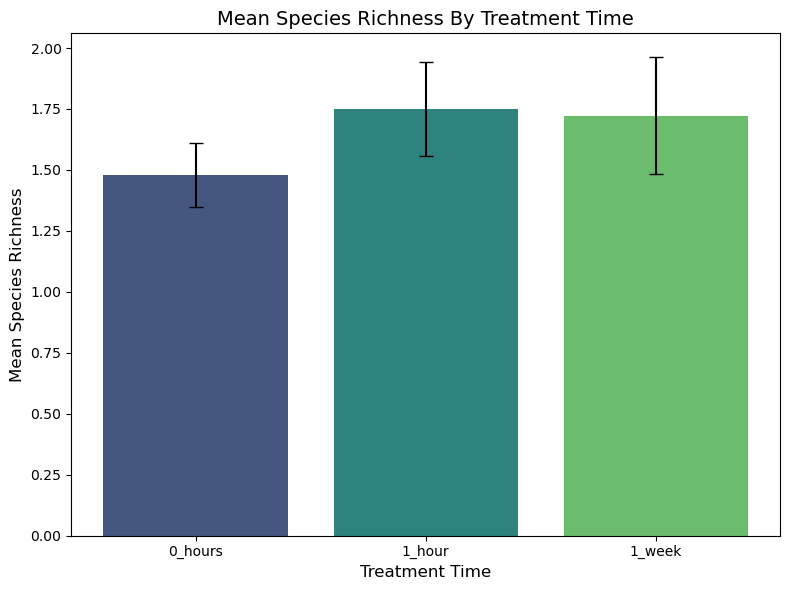


### Plotting total_richness by Relief_Category ###


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\615311356.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)


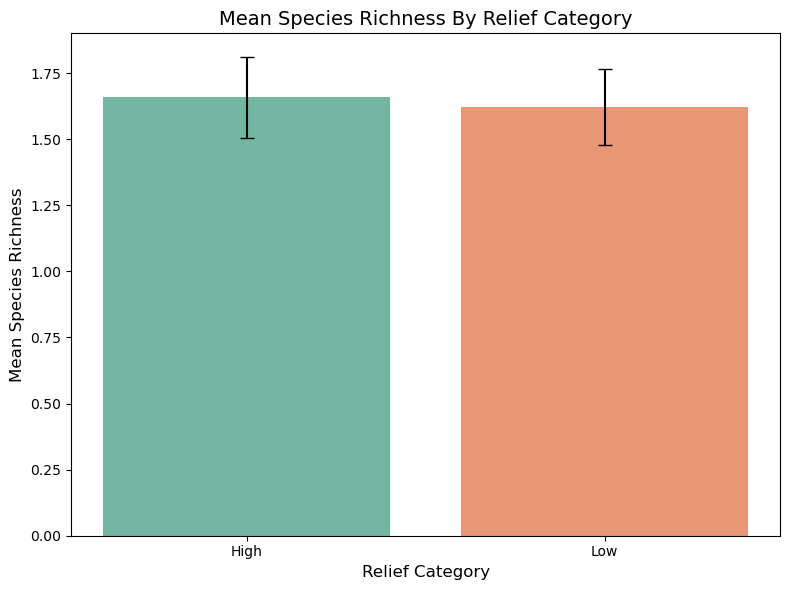


### Plotting total_biodiversity by Mobility ###


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\615311356.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)


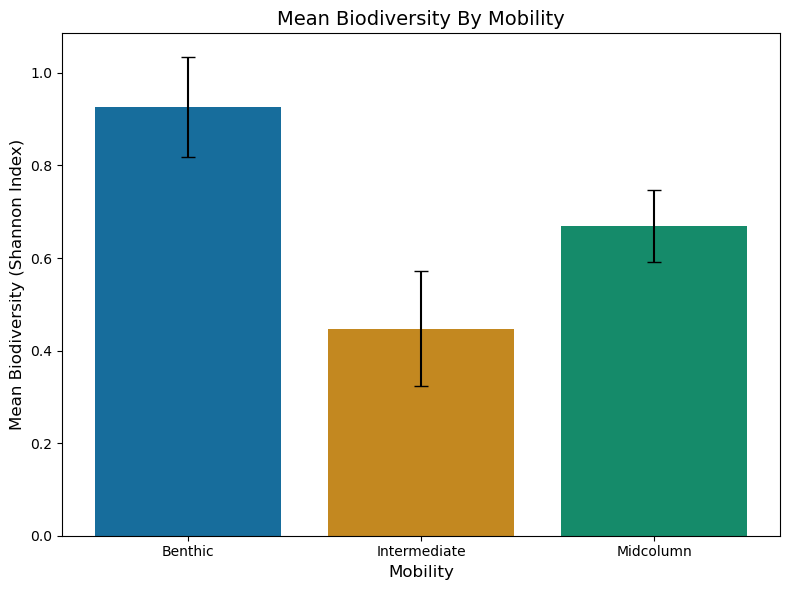


### Plotting total_biodiversity by Treatment_Time ###


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\615311356.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)


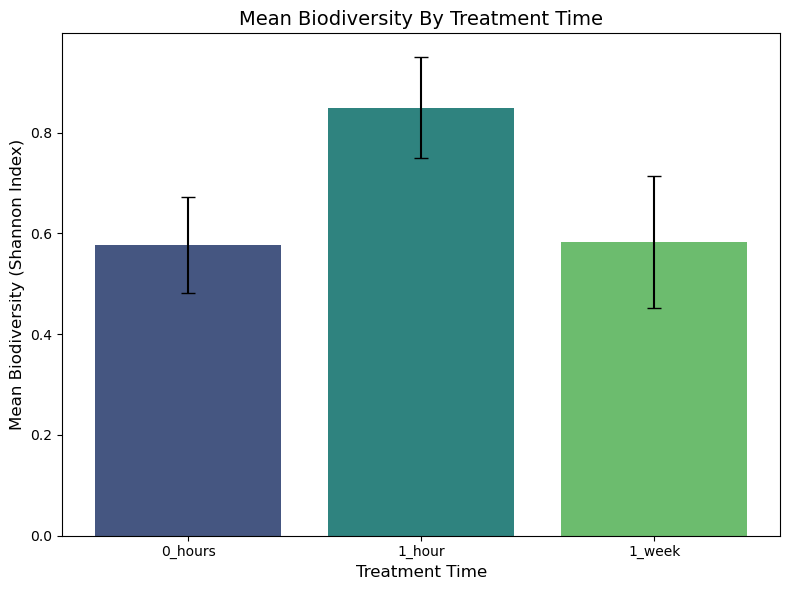


### Plotting total_biodiversity by Relief_Category ###


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18268\615311356.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)


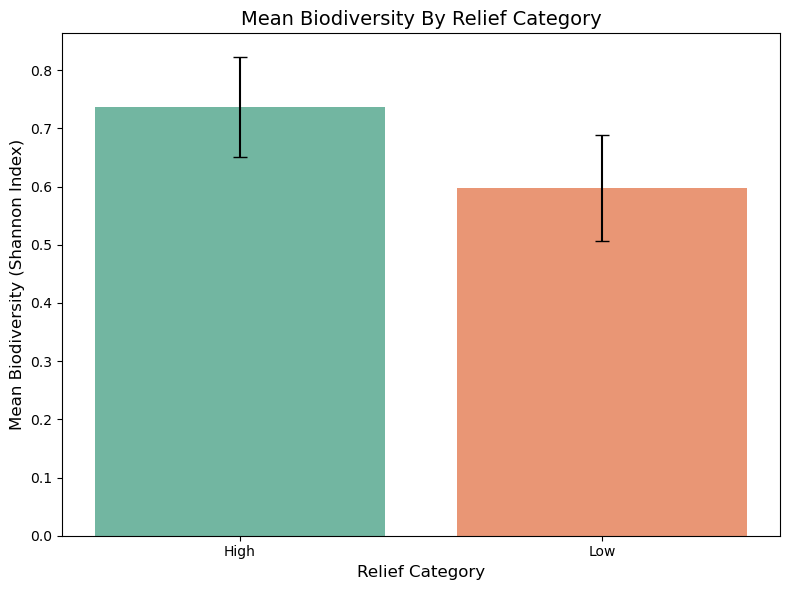

In [103]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to plot the bar plot for a given metric and factor with error bars
def plot_metric_by_factor_bar(stats, metric_column, factor_column, y_label, title, save_path=None, color_palette="muted"):
    """
    Function to plot a bar plot for a given metric and factor with error bars.

    Parameters:
    - stats: DataFrame containing the data
    - metric_column: The name of the metric (e.g., 'total_abundance')
    - factor_column: The name of the factor (e.g., 'Mobility')
    - y_label: Y-axis label (metric label, e.g., 'Total Abundance')
    - title: Plot title (e.g., 'Total Abundance by Mobility')
    - save_path: Path to save the plot as a .jpeg file (optional)
    - color_palette: Seaborn color palette to apply (default is "muted")
    """
    # Filter the data to only include the selected metric
    metric_data = stats[stats['Metric'] == metric_column]
    
    if metric_data.empty:
        print(f"Error: Metric column '{metric_column}' not found in the DataFrame.")
        return

    # Calculate means and standard errors
    metric_stats = metric_data.groupby(factor_column).agg(
        mean_value=('Value', 'mean'),
        std_error=('Value', 'std'),
        count_value=('Value', 'size')
    ).reset_index()

    # Calculate standard error
    metric_stats['std_error'] = metric_stats['std_error'] / np.sqrt(metric_stats['count_value'])

    # Create the bar plot with the selected color palette
    plt.figure(figsize=(8, 6))
    sns.barplot(x=factor_column, y='mean_value', data=metric_stats, errorbar=None, palette=color_palette)

    # Add error bars
    for i, row in metric_stats.iterrows():
        plt.errorbar(i, row['mean_value'], yerr=row['std_error'], fmt='none', color='black', capsize=5)

    # Set plot labels and title
    plt.title(title.replace('_', ' ').title(), fontsize=14)
    plt.xlabel(factor_column.replace('_', ' ').title(), fontsize=12)
    plt.ylabel(y_label.replace('_', ' ').title(), fontsize=12)

    # Show the plot
    plt.tight_layout()

    # Optionally save the plot as a .jpeg
    if save_path:
        # Ensure the directory exists before saving
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, format='jpeg')
    plt.show()

# Define metrics and factors
metrics = ['total_density', 'total_weighted_size', 'total_richness', 'total_biodiversity']
factors = ['Mobility', 'Treatment_Time', 'Relief_Category']

# Define color palettes for each factor
color_palettes = {
    'Mobility': 'colorblind',  # Red-blue palette for Mobility
    'Treatment_Time': 'viridis',  # Sequential palette for Treatment Time
    'Relief_Category': 'Set2'  # Distinct color set for Relief Category
}

# Loop through each metric and factor to plot and save each plot
for metric in metrics:
    for factor in factors:
        print(f"\n### Plotting {metric} by {factor} ###")
        
        # Set y_label and title based on the metric
        if metric == 'total_density':
            y_label = 'Mean Density (count/m²)'
            title = 'Mean Density by ' + factor
        elif metric == 'total_weighted_size':
            y_label = 'Mean Size (cm)'
            title = 'Mean Size by ' + factor
        elif metric == 'total_richness':
            y_label = 'Mean Species Richness'
            title = 'Mean Species Richness by ' + factor
        elif metric == 'total_biodiversity':
            y_label = 'Mean Biodiversity (Shannon Index)'
            title = 'Mean Biodiversity by ' + factor
        
        # Set the path to save the figure as a jpeg
        save_path = f"plots/{metric}_by_{factor}.jpeg"
        
        # Get the appropriate color palette
        color_palette = color_palettes.get(factor, "muted")  # Default to "muted" if not defined

        # Plot the metric by factor and save the figure
        plot_metric_by_factor_bar(melted_df, metric, factor, y_label, title, save_path, color_palette)
